In [1]:
import os
import sys
import numpy as np
import pandas as pd
import scipy
import scipy.special
import itertools
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import collections
from collections import OrderedDict

import plotly
import plotly.offline
import plotly.graph_objs as go

if './src' not in sys.path:
    sys.path.append('./src')
import src.vector_vortex_beams as VVB
import utils
from src.utils import abs2, borderless_imshow_save, imshow_intensities

%matplotlib inline
%load_ext autoreload
%autoreload 2

# Camera resolution
# camera_width = 1024
# camera_height = 768
camera_width = 300
camera_height = 300

Y, X = np.meshgrid(
    np.linspace(-camera_height / 2, camera_height / 2, num=camera_height),
    np.linspace(-camera_width / 2, camera_width / 2, num=camera_width)
)

reference_w0 = 50

# Look how cool OAM states are

Profiles of OAM states with $p=0$ and $m=-5,-4,...,4,5$.

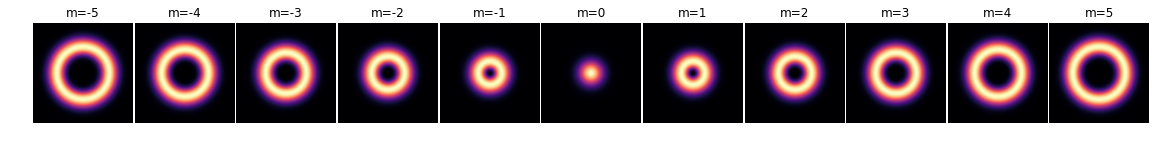

In [26]:
fig, axs = plt.subplots(nrows=1, ncols=11, figsize=(20, 6))
for ax, m in zip(axs, np.arange(-5, 6)):
    amps = VVB.LaguerreGauss(X, Y, p=0, m=m, w0=reference_w0)
    ax.axis('off'); ax.set_title('m={}'.format(m))
    utils.imshow_intensities(amps, ax=ax)
fig.subplots_adjust(hspace=0, wspace=.02)

Profiles of OAM states with $p=1$ and $m=-5,-4,...,4,5$.

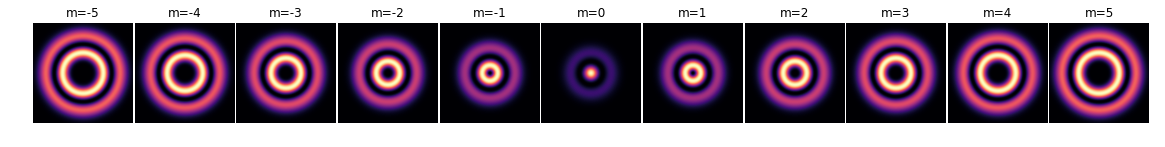

In [27]:
fig, axs = plt.subplots(nrows=1, ncols=11, figsize=(20, 6))
for ax, m in zip(axs, np.arange(-5, 6)):
    amps = VVB.LaguerreGauss(X, Y, p=1, m=m, w0=reference_w0)
    ax.axis('off'); ax.set_title('m={}'.format(m))
    utils.imshow_intensities(amps, ax=ax)
fig.subplots_adjust(hspace=0, wspace=.02)

Superpositions $\lvert 0\rangle+ \lvert m\rangle$ for $m=-4,...,4$:

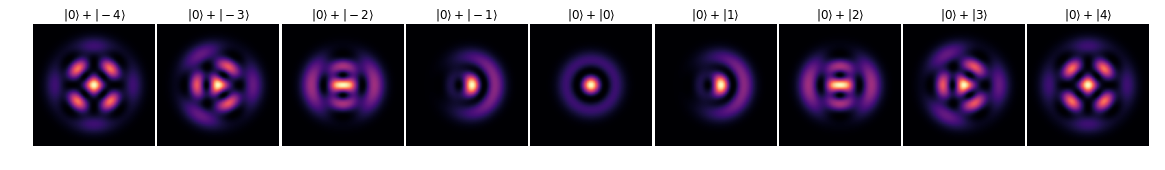

In [28]:
fig, axs = plt.subplots(nrows=1, ncols=9, figsize=(20, 6))
for ax, m in zip(axs, np.arange(-4, 5)):
    amps = VVB.LaguerreGauss(X, Y, p=1, m=0, w0=reference_w0) + VVB.LaguerreGauss(X, Y, p=1, m=m, w0=reference_w0)
    ax.axis('off'); ax.set_title(r'$| 0\rangle + | {}\rangle$'.format(m))
    utils.imshow_intensities(amps, ax=ax)
fig.subplots_adjust(hspace=0, wspace=.02)

Superpositions $\lvert 0\rangle+ i \lvert m\rangle$ for $m=-4,...,4$ (same as above but with $\lvert0\rangle+\lvert k\rangle$ rotated of $\pi/2^k$ degrees?):

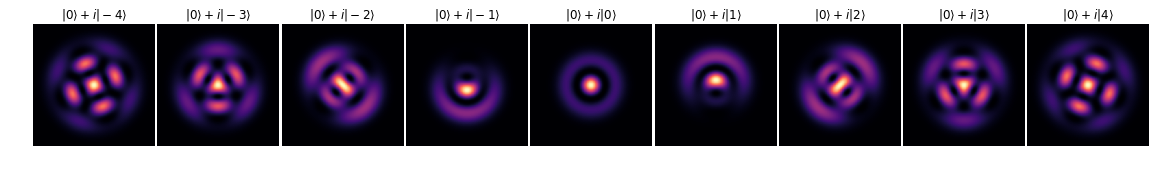

In [4]:
fig, axs = plt.subplots(nrows=1, ncols=9, figsize=(20, 6))
for ax, m in zip(axs, np.arange(-4, 5)):
    amps = VVB.LaguerreGauss(X, Y, p=1, m=0, w0=reference_w0) + 1j * VVB.LaguerreGauss(X, Y, p=1, m=m, w0=reference_w0)
    ax.axis('off'); ax.set_title(r'$| 0\rangle + i| {}\rangle$'.format(m))
    utils.imshow_intensities(amps, ax=ax)
fig.subplots_adjust(hspace=0, wspace=.02)

How much does the profile change by adding noise?

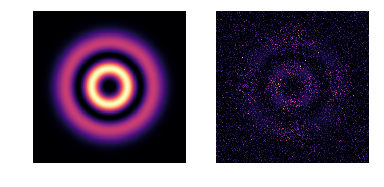

In [5]:
fig, axs = plt.subplots(ncols=2)

data = VVB.LaguerreGauss(X, Y, p=1, m=2, w0=reference_w0)
imshow_intensities(data, ax=axs[0])
data = utils.add_noise_to_array(data, noise_level=0.3)
imshow_intensities(data, ax=axs[1])

# Naive dimensionality reduction with PCA

In [37]:
# generate the tuples (p, (m1, m2)), with p fixed and (m1, m2) changing
tuples_to_generate = []
p_list = [0, 1, 2]
m_list = [0, 1, 2, 3, 4, 5]
for p in p_list:
    for m in m_list:
        tuples_to_generate.append([(p, m)])
tuples_to_generate.append([(1, 1), (1, 2)])
tuples_to_generate.append([(1, 1), (1, 3)])
tuples_to_generate.append([(1, 1), (1, 4)])
# actually generate, reduce, and classify the data
OAM_dataset = VVB.OAMDataset(X=X, Y=Y, w0=reference_w0)
OAM_dataset.generate_data(parameters=tuples_to_generate, num_samples=20, noise_level=0.1, polarization_state='sequential phases', monitor=True)
OAM_dataset.apply_PCA(n_components=20, svd_solver='randomized', whiten=True)
OAM_dataset.fit_SVM(gamma='scale')

100%|██████████| 21/21 [00:09<00:00,  1.67it/s]


Let's see what the principal vectors found by the algorithm look like:

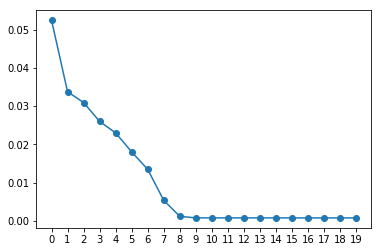

In [20]:
plt.plot(OAM_dataset.pca.singular_values_, 'o-'); plt.xticks(np.arange(20));

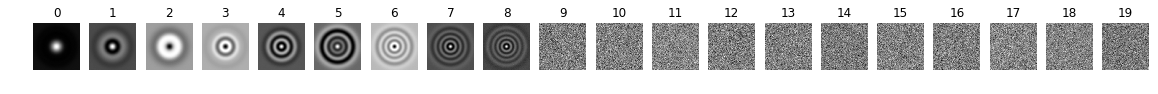

In [21]:
fig, axs = plt.subplots(ncols=20, figsize=(20, 4))
for idx, ax in enumerate(axs):
    ax.imshow(OAM_dataset.pca.components_[idx].reshape((300, 300)), cmap='gray');
    ax.axis('off')
    ax.set_title(idx)

In [198]:
pca.singular_values_

array([0.11425167, 0.07320407, 0.0610202 , 0.05043067, 0.04326235,
       0.04136676, 0.03534813, 0.03210652, 0.02961036, 0.0258944 ,
       0.0230528 , 0.02009286, 0.01717111, 0.01713464, 0.0170599 ,
       0.01703408, 0.01702156, 0.01698691, 0.01692598, 0.01686701])

We see patterns only until a certain point, while the rest seems to be just noise. Interestingly, this is not clearly reflected in the corresponding singular values.
An interesting question might be: how does the number of principal components displaying a noticeable pattern vary with the number of classes using for the training data?

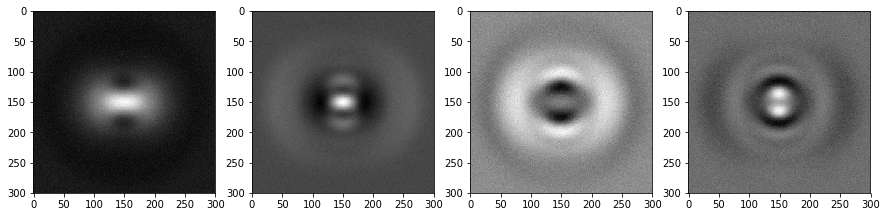

In [169]:
eigenbeams = pca.components_.reshape(pca.components_.shape[0], 300, 300)

fig, axs = plt.subplots(ncols=eigenbeams.shape[0], figsize=(15, 5))
for idx, ax in enumerate(axs):
    ax.imshow(eigenbeams[idx], cmap='gray')

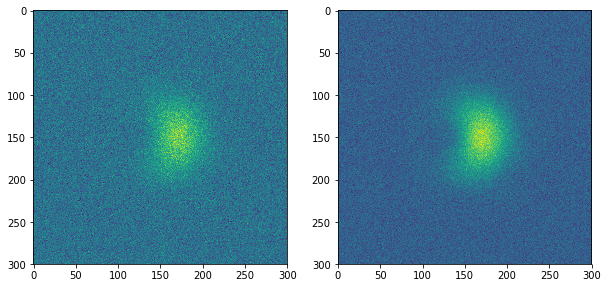

In [203]:
probs = dataset[list(dataset)[4]][20]
funneled_probs = pca.inverse_transform(pca.transform(probs[None, :]))

_, axs = plt.subplots(ncols=2, figsize=(10, 5))

axs[0].imshow(probs.reshape(300, 300))
axs[1].imshow(funneled_probs.reshape(300, 300))

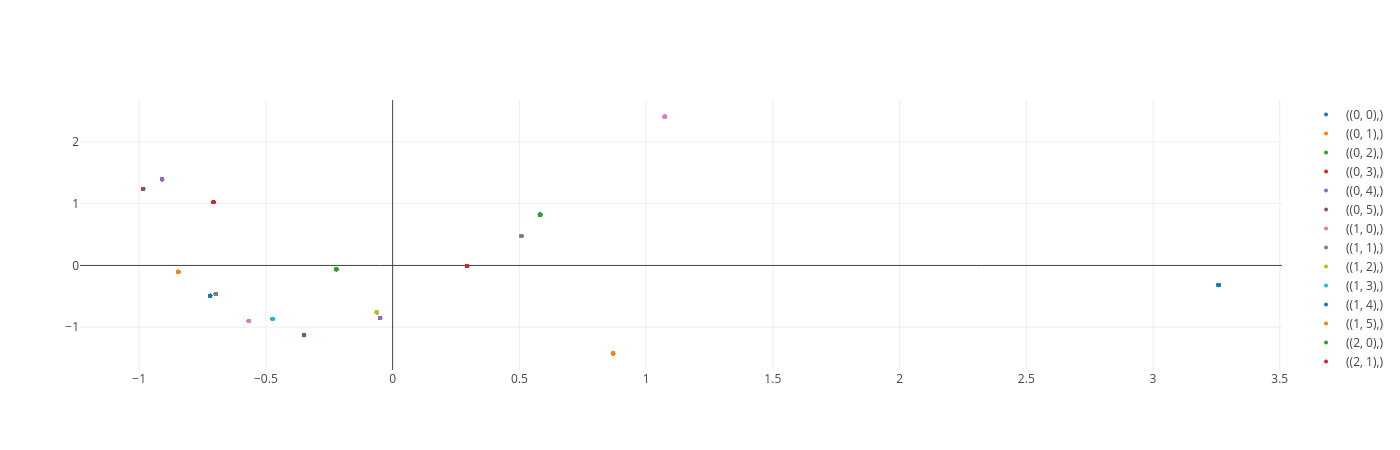

In [36]:
import plotly
import plotly.offline
import plotly.graph_objs as go

traces = []
for idx, label_name in enumerate(OAM_dataset.labels_names):
    reduced_data = OAM_dataset.dataset[np.array(OAM_dataset.labels) == idx]
    reduced_data = OAM_dataset.pca.transform(reduced_data)[:, :2]
    traces.append(go.Scatter(
        x=reduced_data[:, 0],
        y=reduced_data[:, 1],
        mode='markers',
        name=str(label_name),
        marker=dict(size=4)
    ))

plotly.offline.iplot(traces)

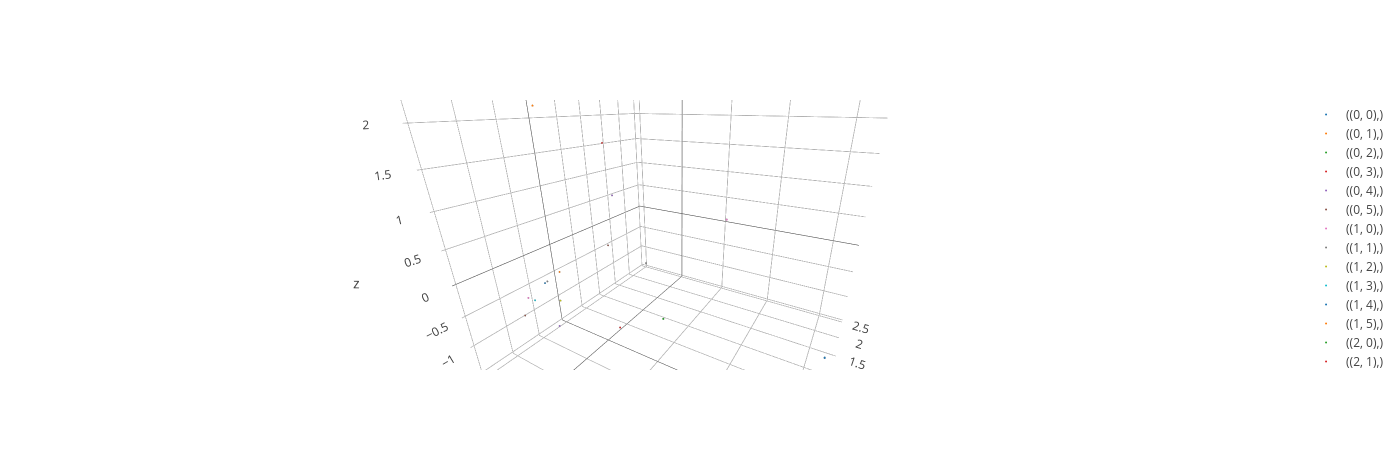

In [33]:
import plotly
import plotly.offline
import plotly.graph_objs as go

traces = []
for idx, label_name in enumerate(OAM_dataset.labels_names):
    reduced_data = OAM_dataset.dataset[np.array(OAM_dataset.labels) == idx]
    reduced_data = OAM_dataset.pca.transform(reduced_data)[:, :3]
    traces.append(go.Scatter3d(
        x=reduced_data[:, 0],
        y=reduced_data[:, 1],
        z=reduced_data[:, 2],
        mode='markers',
        name=str(label_name),
        marker=dict(size=1)
    ))

plotly.offline.iplot(traces)

Generate a bunch of images for classification of different basis states

# Look how nice VVBs are

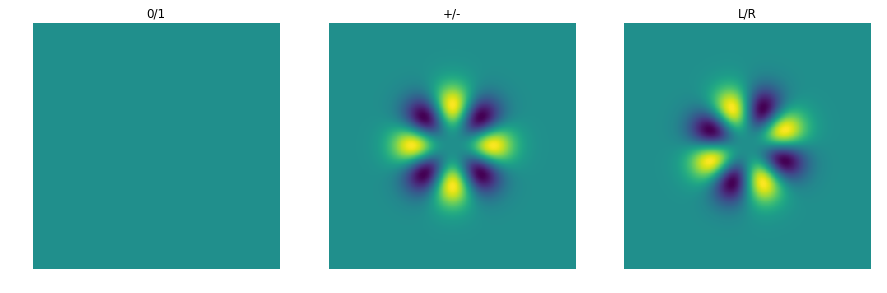

In [2]:
stokes_pars = VVB.vector_vortex_stokes_pars(X, Y, p=0, m_pair=[-2, 2], w0=reference_w0, polarization_state=[1, 1] / np.sqrt(2))
stokes_pars = utils.make_into_rgb_format(stokes_pars)

fig, axs = plt.subplots(ncols=3, figsize=(15, 5))
utils.imshow_stokes_probs(stokes_pars, axs=axs, imshow_opts=dict(vmin=stokes_pars.min(), vmax=stokes_pars.max()), show_axis=False);
# fig.colorbar(axs[1].images[0], ax=axs.ravel().tolist());

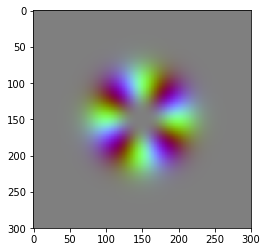

In [43]:
stokes_pars = VVB.vector_vortex_stokes_pars(X, Y, p=0, m_pair=[-2, 2], w0=reference_w0, polarization_state=[1, 1] / np.sqrt(2))
plt.imshow(utils.make_into_rgb_format(stokes_pars));

# Apply PCA + SVC to classify VVBs

In [80]:
# generate the tuples (p, (m1, m2)), with p fixed and (m1, m2) changing
p = 1
tuples_to_generate = []
m_list = [-5, -3, -1, 1, 3, 5]
for (m, n) in list(itertools.combinations_with_replacement(m_list, r=2)):
    if (p, (-m, -n)) not in tuples_to_generate:
        tuples_to_generate.append((p, (m, n)))

# actually generate, reduce, and classify the data
dataset = VVB.VVBDataset(X=X, Y=Y, w0=reference_w0)
dataset.generate_data(parameters=tuples_to_generate, num_samples=100, noise_level=0.1, polarization_state='sequential phases', monitor=True)
dataset.apply_PCA(n_components=20, svd_solver='randomized', whiten=True)
dataset.fit_SVM(gamma='scale')

100%|██████████| 18/18 [01:22<00:00,  4.53s/it]


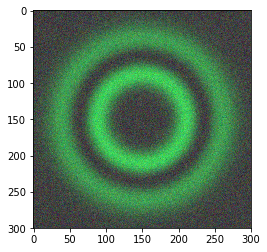

In [106]:
plt.imshow(utils.rescale_array_values(np.transpose(dataset.dataset[3].reshape((3, 300, 300)), [1, 2, 0]), [0, 255]).astype(np.uint8))

Save the generated images as png files:

In [107]:
for label_idx, label_name in enumerate(dataset.labels_names):
    path = './images/noise0.1/{}'.format(label_name)
    path = path.replace(' ', '')
    os.makedirs(path, exist_ok=True)
    data_per_label = dataset.dataset[np.array(dataset.labels) == label_idx]
    for image_idx, image_data in enumerate(data_per_label):
        image_data = image_data.reshape((3, 300, 300))
        image_data = np.transpose(image_data, [1, 2, 0])
        image_data = utils.rescale_array_values(image_data, [0, 255]).astype(np.uint8)
        filename = os.path.join(path, '({:03}).png'.format(image_idx))
        utils.borderless_imshow_save(image_data, outputname=filename)

In [9]:
# import pickle
# import copy
# dataset_to_save = copy.deepcopy(dataset)
# del dataset_to_save.dataset
# with open('trained_dataset_pca+svc_p1_noice0.01.pickle', 'wb') as fp:
#     pickle.dump(dataset_to_save, fp)

Load and show an image loaded from file:

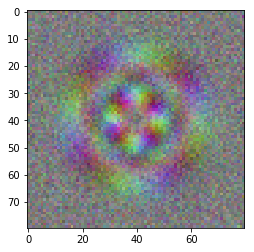

In [108]:
import glob
filenames = glob.glob('./images/noise0.1/**/*.png', recursive=True)
images = np.zeros(shape=(len(filenames), 80, 80, 3))
for idx, filename in enumerate(filenames):
    images[idx] = plt.imread(filename)[:, :, :3]
plt.imshow(images[0]);

Show first principal components found by the PCA.

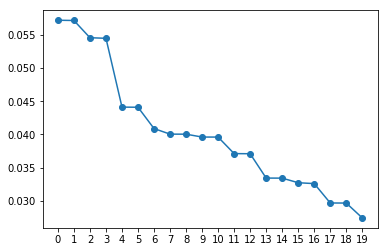

In [109]:
plt.plot(dataset.pca.singular_values_, 'o-')
plt.xticks(np.arange(20));

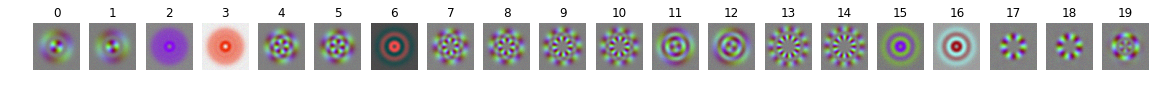

In [110]:
fig, axs = plt.subplots(ncols=20, figsize=(20, 4))
for idx, ax in enumerate(axs):
    ax.imshow(utils.make_into_rgb_format(dataset.pca.components_[idx].reshape((3, 300, 300))));
    ax.axis('off')
    ax.set_title(idx)

Ten effective dimensions are already enough to reproduce with good accuracy even more complex features:

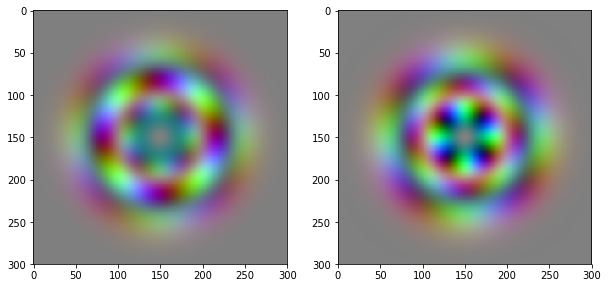

In [78]:
data = dataset.dataset[200]
img = data.reshape((3, 300, 300))
filtered_img = dataset.cut_feature_space_components(data[None, :], num_dimensions=10).reshape((3, 300, 300))

fig, axs = plt.subplots(ncols=2, figsize=(10, 5))
axs[0].imshow(utils.make_into_rgb_format(img))

axs[1].imshow(utils.make_into_rgb_format(filtered_img));

Test classifier on training data

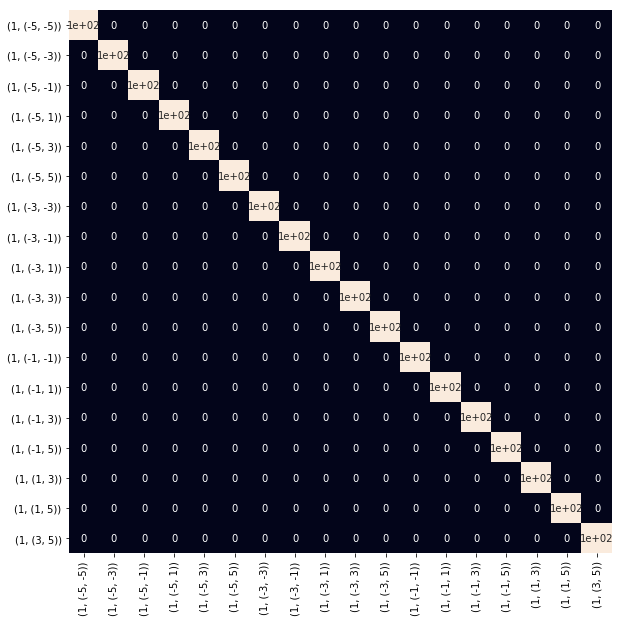

In [83]:
predicted_features = VVB.accuracies_from_predictions(
    true_labels=np.array(dataset.labels),
    predicted_labels=dataset.reduce_and_classify(dataset.dataset),
    labels_names=dataset.labels_names
)

_, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.heatmap(
    data=list(predicted_features.values()), ax=ax,
    annot=True, square=True, cbar=False,
    xticklabels=predicted_features.keys(), yticklabels=predicted_features.keys()
);

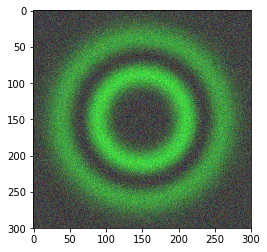

In [108]:
img = dataset.dataset[np.argwhere(dataset.labels == np.array(0))[0][0]].reshape((3, 300, 300))
plt.imshow(utils.make_into_rgb_format(img));

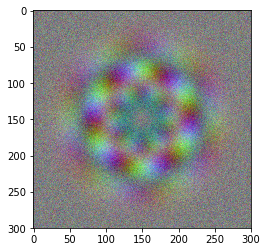

In [110]:
img = dataset.dataset[np.argwhere(dataset.labels == np.array(3))[0][0]].reshape((3, 300, 300))
plt.imshow(utils.make_into_rgb_format(img));

Test classification on a freshly generated dataset:

100%|██████████| 18/18 [00:34<00:00,  1.81s/it]


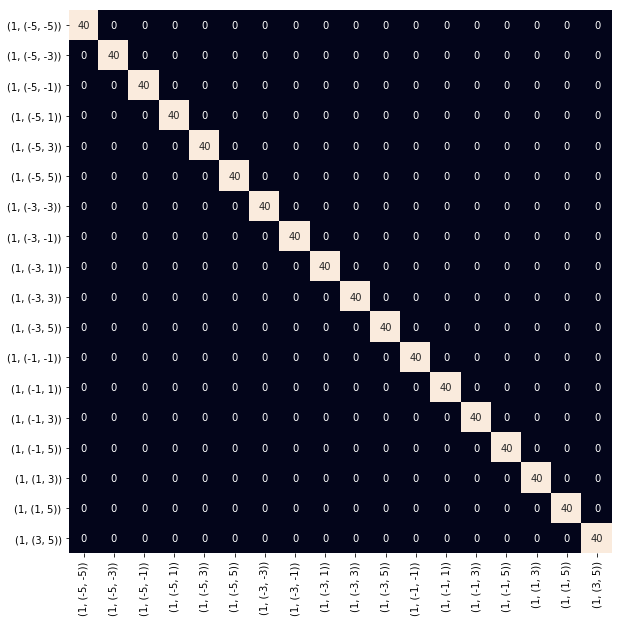

In [84]:
test_dataset = VVB.VVBDataset(X=X, Y=Y, w0=reference_w0)
test_dataset.generate_data(parameters=tuples_to_generate, num_samples=40, noise_level=0.1, polarization_state='random phases', monitor=True)

predicted_features = VVB.accuracies_from_predictions(
    true_labels=np.array(test_dataset.labels),
    predicted_labels=dataset.reduce_and_classify(test_dataset.dataset),
    labels_names=dataset.labels_names
)

_, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.heatmap(
    data=list(predicted_features.values()), ax=ax,
    annot=True, square=True, cbar=False,
    xticklabels=predicted_features.keys(), yticklabels=predicted_features.keys()
);

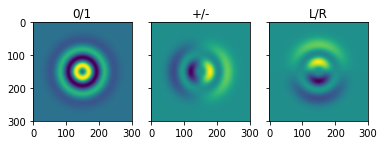

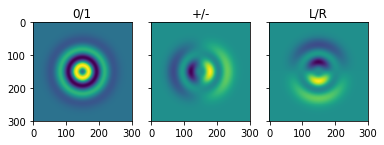

In [178]:
utils.imshow_stokes_probs(VVB.vector_vortex_stokes_pars(X, Y, p=1, m_pair=(1, 2), w0=reference_w0, polarization_state=[1, 1] / np.sqrt(2)))

utils.imshow_stokes_probs(VVB.vector_vortex_stokes_pars(X, Y, p=1, m_pair=(-1, -2), w0=reference_w0, polarization_state=[1, 1] / np.sqrt(2)));

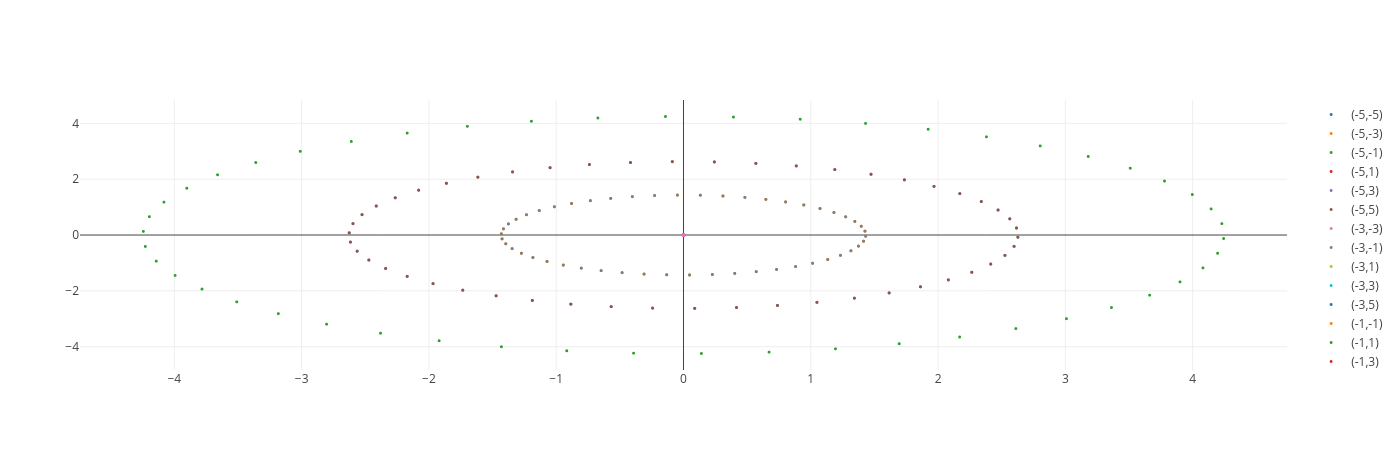

In [197]:
traces = []
for name, data in dataset.items():
    reduced_data = pca.transform(data)[:, :2]
    traces.append(go.Scatter(
        x=reduced_data[:, 0],
        y=reduced_data[:, 1],
#         z=reduced_data[:, 2],
        mode='markers',
        name=name,
        marker=dict(size=3)
    ))

plotly.offline.iplot(traces)

In [198]:
import plotly
import plotly.offline
import plotly.graph_objs as go

reduced_data = pca.transform(data)[:, :3]
colors = ['blue', 'red', 'green', 'purple']
traces = []
for name, data in dataset.items():
    reduced_data = pca.transform(data)
    traces.append(go.Scatter3d(
        x=reduced_data[:, 0],
        y=reduced_data[:, 1],
        z=reduced_data[:, 2],
        mode='markers',
        name=name,
        marker=dict(size=2)
    ))

plotly.offline.plot(traces, filename='stargate.html')

'file:///home/lk/Documents/docs/research/OAM_2016/CNN-for-VVB/stargate.html'

# Taira stuff

In [15]:
#projectors for stokes measurements


sV_op = np.dot(rotated_HWP_matrix(45), rotated_QWP_matrix(0))
sH_op = np.dot(rotated_HWP_matrix(0), rotated_QWP_matrix(0))
sD_op = np.dot(rotated_HWP_matrix(22.5), rotated_QWP_matrix(45))
sA_op = np.dot(rotated_HWP_matrix(-22.5), rotated_QWP_matrix(45))
sL_op = np.dot(rotated_HWP_matrix(22.5), rotated_QWP_matrix(0))
sR_op = np.dot(rotated_HWP_matrix(-22.5), rotated_QWP_matrix(0))

# #polarization states
# L = [1, -1j] / np.sqrt(2)
# R = [1, 1j] / np.sqrt(2)
# D = [1, 1] / np.sqrt(2)
# A = [1, -1] / np.sqrt(2)
# H = np.array([1, 0])
# V = np.array([0, 1])


def pol_state(state1, state2, beta, alpha): 
    return np.array([
        np.cos(np.radians(alpha / 2)) * state1,
        np.exp(1j * np.radians(beta)) * np.sin(np.radians(alpha / 2)) * state2
    ])


def rotate_state(rotation_matrix, state):
    return np.dot(rotation_matrix, np.transpose(state))


def vec_vortex(coeff,x,y,p,m1,m2,w0):
    return np.round(coeff[0],6)*LG(x,y,p,m2,w0)+np.round(coeff[1],6)*LG(x,y,p,m1,w0)


def stokes_para(Iv,Ih):
    return Ih - Iv

In [ ]:
#VVB generation with LG
w0=150
m1=-5
m2=1
beta=0
alpha=90

v_mes = measurement(sV_op, pol_state(L, R, beta, alpha))[0]
h_mes = measurement(sH_op, pol_state(L, R, beta, alpha))[0]
d_mes = measurement(sD_op, pol_state(L, R, beta, alpha))[0]
a_mes = measurement(sA_op, pol_state(L, R, beta, alpha))[0]
l_mes = measurement(sL_op, pol_state(L, R, beta, alpha))[0]
r_mes = measurement(sR_op, pol_state(L, R, beta, alpha))[0]

v_vortex = vec_vortex(v_mes, X, Y, 0, m1, m2, w0)
h_vortex = vec_vortex(h_mes, X, Y, 0, m1, m2, w0)
d_vortex = vec_vortex(d_mes, X, Y, 0, m1, m2, w0)
a_vortex = vec_vortex(a_mes, X, Y, 0, m1, m2, w0)
l_vortex = vec_vortex(l_mes, X, Y, 0, m1, m2, w0)
r_vortex = vec_vortex(r_mes, X, Y, 0, m1, m2, w0)

Iv = np.abs(np.transpose(v_vortex))**2
Ih = np.abs(np.transpose(h_vortex))**2
Id = np.abs(np.transpose(d_vortex))**2
Ia = np.abs(np.transpose(a_vortex))**2
Il = np.abs(np.transpose(l_vortex))**2
Ir = np.abs(np.transpose(r_vortex))**2


s1 = stokes_para(Ih, Iv)
s2 = stokes_para(Id, Ia)
s3 = stokes_para(Il, Ir)
s_vector = np.dstack((s1, s2, s3))

In [ ]:
#Checking beam shapes on each polarization basis
fig, axs = plt.subplots(nrows=1, ncols=6)
beams = [Ih, Iv, Id, Ia, Il, Ir]
bases = ['H', 'V', 'D', 'A', 'L', 'R']
c=0
for ax, beam, label in zip(axs, beams, bases):
    ax.imshow(beam, interpolation='nearest', cmap='inferno')
    ax.axis('off')
    ax.set_title(label)

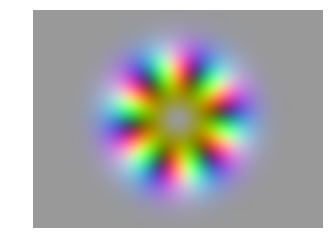

In [ ]:
#Polarization patterns econding in RGB colors

stokes=s_vector+np.abs(np.min(s_vector))
#la formula qui sopra mi serve perchè i parametri di Stokes possono essere negativi
#e nella conversione in un colore RGB dà fastidio.
#Quello che faccio è traslare il centro della sfera di Bloch da (0,0,0) a (1,1,1)
#Con le immagini teoriche ho problemi a calcolarmi i parametri di Stokes normalizzati (esplode
#quando deve fare 0/0), infatti la funzione stokes-para non ha il denominatore, e per
#questo traslo di np.abs(np.min(s_vector)) e non di 1 come faccio durante le acquisizioni
#dall'apparato (lì la camera ha un fondo !=0 e non capita mai una divisione 0/0 e 
#riesco ad ottenere i parametri normalizzati). Quesa cosa comunque funziona molto bene, 
#tranne che in prossimità
#dei poli in cui questo codice va un po' adattato ai casi.


rescaled=(256/(np.max(stokes))*(stokes)).astype(np.uint8)

plt.imshow(rescaled,interpolation='nearest')
plt.axis('off')
plt.show()